In [1]:
!nvidia-smi

Sat Feb 24 22:42:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   49C    P8              22W / 215W |   1519MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
sr = 16000
data_dir = '../data/data_preprocessed/meld/features_4balanced/'
data_x = np.load(f'{data_dir}meld.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}meld.label_emotion.npy', allow_pickle=True)

In [7]:
print(len(data_x))
print(len(data_y))

8499
8499


In [8]:
labels = list(np.unique(data_y))
labels

[0, 1, 2, 3]

In [9]:
classnames = ['ang', 'hap', 'neu', 'sad']
emo3_labels = ['ang', 'neu', 'sad']

def label_filter(idx):
    return classnames[idx] in emo3_labels

def label_to_index(idx):
    return emo3_labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(6776,)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 5420
Test: 1356


In [11]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [12]:
labels = emo3_labels

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 8

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
import traceback

In [15]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18_cqt.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 1, 'n_channel': [512], 'kernel_size': [127], 'stride': [16], 'window_k': [9], 'mel_resolution': 4, 'residual_connection_type': 'concat', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 48, 'out_seq_length': 16, 'use_context': False, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [128, 128], 'norm_type': 'LayerNorm', 'dropout': 0.05}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(512, 48, batch_first=True)
    (pad_layer): PadF

In [16]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [17]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [17]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                              | 0.002364066193853428/10 [00:00<40:54, 245.46s/it]

Train Epoch: 1 [0/5420 (0%)]	Loss: 0.979267
Mem before-during-after: 2124288 1993563648 27947008


  0%|▏                              | 0.04964539007092203/10 [00:08<28:16, 170.51s/it]

Train Epoch: 1 [320/5420 (6%)]	Loss: 0.474919
Mem before-during-after: 27947008 1996707328 27947008


  1%|▎                              | 0.09574468085106394/10 [00:17<31:38, 191.66s/it]

Train Epoch: 1 [640/5420 (12%)]	Loss: 0.855158
Mem before-during-after: 27947008 1988540416 27947008


  1%|▍                              | 0.14420803782505928/10 [00:26<29:08, 177.37s/it]

Train Epoch: 1 [960/5420 (18%)]	Loss: 1.071928
Mem before-during-after: 27947008 1995658752 27947008


  2%|▌                               | 0.1914893617021279/10 [00:34<29:26, 180.12s/it]

Train Epoch: 1 [1280/5420 (24%)]	Loss: 0.614521
Mem before-during-after: 27947008 1995658752 27947008


  2%|▋                              | 0.23877068557919653/10 [00:43<28:32, 175.42s/it]

Train Epoch: 1 [1600/5420 (30%)]	Loss: 0.983383
Mem before-during-after: 27947008 1995658752 27947008


  3%|▉                              | 0.28605200945626513/10 [00:51<28:14, 174.40s/it]

Train Epoch: 1 [1920/5420 (35%)]	Loss: 0.735115
Mem before-during-after: 27947008 1995658752 27947008


  3%|█                              | 0.33333333333333376/10 [01:00<28:51, 179.11s/it]

Train Epoch: 1 [2240/5420 (41%)]	Loss: 1.038381
Mem before-during-after: 27947008 1993561600 27947008


  4%|█▏                              | 0.3806146572104024/10 [01:09<28:13, 176.02s/it]

Train Epoch: 1 [2560/5420 (47%)]	Loss: 0.518595
Mem before-during-after: 27947008 1993561600 27947008


  4%|█▍                               | 0.427895981087471/10 [01:17<27:59, 175.42s/it]

Train Epoch: 1 [2880/5420 (53%)]	Loss: 0.787527
Mem before-during-after: 27947008 1993561600 27947008


  5%|█▍                             | 0.47517730496453964/10 [01:25<27:11, 171.30s/it]

Train Epoch: 1 [3200/5420 (59%)]	Loss: 0.990957
Mem before-during-after: 27947008 1993561600 27947008


  5%|█▋                              | 0.5224586288416072/10 [01:34<27:50, 176.23s/it]

Train Epoch: 1 [3520/5420 (65%)]	Loss: 0.292365
Mem before-during-after: 27947008 1991560704 27947008


  6%|█▊                              | 0.5697399527186736/10 [01:42<27:59, 178.07s/it]

Train Epoch: 1 [3840/5420 (71%)]	Loss: 0.842764
Mem before-during-after: 27947008 1991560704 27947008


  6%|██                                | 0.61702127659574/10 [01:51<28:12, 180.41s/it]

Train Epoch: 1 [4160/5420 (77%)]	Loss: 0.589119
Mem before-during-after: 27947008 1991560704 27947008


  7%|██▏                             | 0.6643026004728064/10 [01:59<27:20, 175.72s/it]

Train Epoch: 1 [4480/5420 (83%)]	Loss: 0.790951
Mem before-during-after: 27947008 1991560704 27947008


  7%|██▎                             | 0.7115839243498728/10 [02:08<29:10, 188.47s/it]

Train Epoch: 1 [4800/5420 (89%)]	Loss: 1.383428
Mem before-during-after: 27947008 1991540224 27947008


  8%|██▍                             | 0.7588652482269392/10 [02:17<28:25, 184.61s/it]

Train Epoch: 1 [5120/5420 (95%)]	Loss: 0.592290
Mem before-during-after: 27959808 1991553024 27959808


 10%|███▏                            | 0.9999999999999779/10 [02:53<21:47, 145.22s/it]


Test Epoch: 1	Accuracy: 934/1352 (69%)



 10%|███▏                            | 1.0023640661938313/10 [02:54<23:22, 155.89s/it]

Train Epoch: 2 [0/5420 (0%)]	Loss: 0.729934
Mem before-during-after: 27957248 2008330240 27959808


 10%|███▎                            | 1.0496453900709022/10 [03:02<26:41, 178.90s/it]

Train Epoch: 2 [320/5420 (6%)]	Loss: 1.088012
Mem before-during-after: 27947008 1995638272 27947008


 11%|███▌                             | 1.096926713947973/10 [03:11<26:06, 175.99s/it]

Train Epoch: 2 [640/5420 (12%)]	Loss: 1.113067
Mem before-during-after: 27947008 1995638272 27947008


 11%|███▋                            | 1.1442080378250439/10 [03:19<26:55, 182.46s/it]

Train Epoch: 2 [960/5420 (18%)]	Loss: 1.076583
Mem before-during-after: 27947008 1995638272 27947008


 12%|███▊                            | 1.1914893617021147/10 [03:28<26:00, 177.17s/it]

Train Epoch: 2 [1280/5420 (24%)]	Loss: 0.577712
Mem before-during-after: 27947008 1995638272 27947008


 12%|███▉                            | 1.2387706855791856/10 [03:36<26:01, 178.22s/it]

Train Epoch: 2 [1600/5420 (30%)]	Loss: 0.659253
Mem before-during-after: 27947008 1995638272 27947008


 13%|████                            | 1.2848699763593296/10 [03:45<27:49, 191.55s/it]

Train Epoch: 2 [1920/5420 (35%)]	Loss: 0.354310
Mem before-during-after: 27947008 1995638272 27947008


 13%|████▍                             | 1.28841607565011/10 [03:45<26:23, 181.80s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f09a97921c0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 13%|████▏                           | 1.2895981087470367/10 [03:46<25:27, 175.38s/it]


KeyboardInterrupt: 


KeyboardInterrupt



ERROR! Session/line number was not unique in database. History logging moved to new session 312


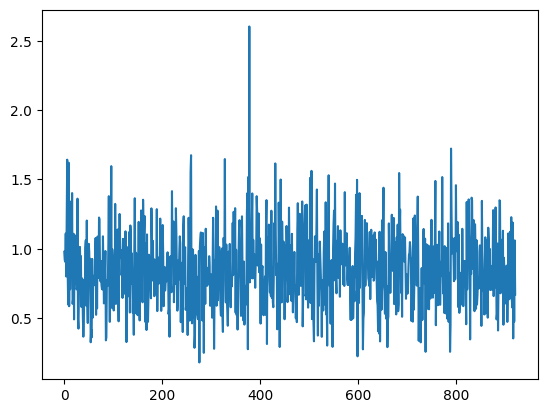

In [18]:
plt.plot(train_losses)

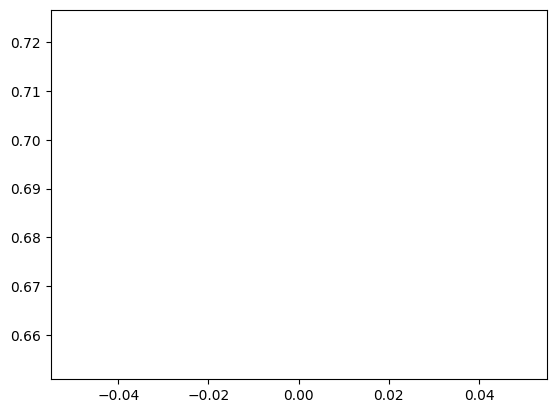

In [19]:
plt.plot(test_accuracy)

In [20]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [21]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 934/1352 (0.6908)
{'acc_detail': tensor([1., 0., 0.], device='cuda:0'),
 'acc_unweighted': tensor(0.3333, device='cuda:0'),
 'acc_weighted': tensor(0.6908, device='cuda:0'),
 'f1s': tensor(0.2724, device='cuda:0'),
 'f1s_detail': tensor([0.8171, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.6908, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0.], device='cuda:0'),
 'rocauc': tensor([0.5524, 0.5273, 0.5701], device='cuda:0'),
 'uar': tensor(0.3333, device='cuda:0'),
 'wap': tensor(0.4772, device='cuda:0')}


tensor([[934,   0,   0],
        [160,   0,   0],
        [258,   0,   0]], device='cuda:0')

In [23]:
n_epoch = 10
n_epoch2 = 10
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_meld4/meld3_m18emo4_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                              | 0.001182033096926714/10 [00:00<35:38, 213.91s/it]

Train Epoch: 11 [0/5420 (0%)]	Loss: 0.615261
Mem before-during-after: 34658816 2016107520 50489344


  0%|▏                             | 0.048463356973995314/10 [00:09<34:20, 207.06s/it]

Train Epoch: 11 [320/5420 (6%)]	Loss: 1.475656
Mem before-during-after: 50489344 2020324864 50489344


  1%|▎                              | 0.09692671394799066/10 [00:19<32:28, 196.74s/it]

Train Epoch: 11 [640/5420 (12%)]	Loss: 0.979842
Mem before-during-after: 50489344 2020324864 50489344


  1%|▍                              | 0.14302600472813257/10 [00:28<33:43, 205.25s/it]

Train Epoch: 11 [960/5420 (18%)]	Loss: 0.575979
Mem before-during-after: 50489344 2020324864 50489344


  2%|▌                               | 0.1903073286052012/10 [00:37<34:00, 208.05s/it]

Train Epoch: 11 [1280/5420 (24%)]	Loss: 1.034655
Mem before-during-after: 50489344 2020324864 50489344


  2%|▋                              | 0.23758865248226982/10 [00:47<33:39, 206.89s/it]

Train Epoch: 11 [1600/5420 (30%)]	Loss: 0.821762
Mem before-during-after: 50489344 2019276288 50489344


  3%|▉                               | 0.2848699763593384/10 [00:56<33:43, 208.32s/it]

Train Epoch: 11 [1920/5420 (35%)]	Loss: 0.799971
Mem before-during-after: 50489344 2019287040 50489344


  3%|█                              | 0.33215130023640704/10 [01:06<32:37, 202.50s/it]

Train Epoch: 11 [2240/5420 (41%)]	Loss: 1.001457
Mem before-during-after: 50489344 2019287040 50489344


  4%|█▏                             | 0.37943262411347567/10 [01:15<32:46, 204.46s/it]

Train Epoch: 11 [2560/5420 (47%)]	Loss: 0.623884
Mem before-during-after: 50489344 2019287040 50489344


  4%|█▍                               | 0.427895981087471/10 [01:25<31:23, 196.80s/it]

Train Epoch: 11 [2880/5420 (53%)]	Loss: 1.000046
Mem before-during-after: 50489344 2019287040 50489344


  5%|█▌                              | 0.4739952718676129/10 [01:34<32:51, 206.92s/it]

Train Epoch: 11 [3200/5420 (59%)]	Loss: 0.862162
Mem before-during-after: 50489344 2018227712 50489344


  5%|█▋                              | 0.5224586288416072/10 [01:43<30:18, 191.84s/it]

Train Epoch: 11 [3520/5420 (65%)]	Loss: 0.981545
Mem before-during-after: 50489344 2018227712 50489344


  6%|█▉                               | 0.568557919621747/10 [01:53<33:27, 212.85s/it]

Train Epoch: 11 [3840/5420 (71%)]	Loss: 1.002122
Mem before-during-after: 50489344 2018227712 50489344


  6%|█▉                              | 0.6158392434988134/10 [02:02<32:22, 206.95s/it]

Train Epoch: 11 [4160/5420 (77%)]	Loss: 0.482565
Mem before-during-after: 50489344 2018227712 50489344


  7%|██                              | 0.6631205673758798/10 [02:11<32:00, 205.67s/it]

Train Epoch: 11 [4480/5420 (83%)]	Loss: 0.908782
Mem before-during-after: 50489344 2018227712 50489344


  7%|██▎                             | 0.7104018912529462/10 [02:21<31:47, 205.31s/it]

Train Epoch: 11 [4800/5420 (89%)]	Loss: 0.755751
Mem before-during-after: 50489344 2018227712 50489344


  8%|██▍                             | 0.7576832151300126/10 [02:30<34:58, 227.09s/it]

Train Epoch: 11 [5120/5420 (95%)]	Loss: 1.277495
Mem before-during-after: 50489344 2018227712 50489344


 10%|███▏                            | 0.9999999999999779/10 [03:12<25:02, 167.00s/it]


Test Epoch: 11	Accuracy: 934/1352 (69%)



 10%|███▏                            | 1.0011820330969046/10 [03:12<27:15, 181.79s/it]

Train Epoch: 12 [0/5420 (0%)]	Loss: 0.599434
Mem before-during-after: 50486784 2020546560 50489344


 10%|███▎                            | 1.0496453900709022/10 [03:22<28:49, 193.23s/it]

Train Epoch: 12 [320/5420 (6%)]	Loss: 0.920657
Mem before-during-after: 50489344 2019276288 50489344


 11%|███▌                            | 1.0957446808510463/10 [03:31<30:21, 204.52s/it]

Train Epoch: 12 [640/5420 (12%)]	Loss: 0.905017
Mem before-during-after: 50489344 2019276288 50489344


 11%|███▊                             | 1.143026004728117/10 [03:41<29:48, 201.94s/it]

Train Epoch: 12 [960/5420 (18%)]	Loss: 0.316416
Mem before-during-after: 50489344 2019276288 50489344


 12%|███▉                             | 1.190307328605188/10 [03:50<29:22, 200.07s/it]

Train Epoch: 12 [1280/5420 (24%)]	Loss: 0.354027
Mem before-during-after: 50489344 2018227712 50489344


 12%|███▉                            | 1.2387706855791856/10 [04:00<28:05, 192.40s/it]

Train Epoch: 12 [1600/5420 (30%)]	Loss: 0.504291
Mem before-during-after: 50489344 2018227712 50489344


 13%|████                            | 1.2848699763593296/10 [04:09<29:03, 200.08s/it]

Train Epoch: 12 [1920/5420 (35%)]	Loss: 0.519567
Mem before-during-after: 50489344 2018227712 50489344


 13%|████▎                           | 1.3321513002364005/10 [04:18<29:40, 205.46s/it]

Train Epoch: 12 [2240/5420 (41%)]	Loss: 0.672742
Mem before-during-after: 50489344 2018227712 50489344


 14%|████▍                           | 1.3794326241134713/10 [04:27<29:56, 208.37s/it]

Train Epoch: 12 [2560/5420 (47%)]	Loss: 1.115227
Mem before-during-after: 50489344 2018227712 50489344


 14%|████▋                            | 1.427895981087469/10 [04:37<27:24, 191.80s/it]

Train Epoch: 12 [2880/5420 (53%)]	Loss: 0.657056
Mem before-during-after: 50489344 2018227712 50489344


 15%|████▋                           | 1.4751773049645398/10 [04:46<27:22, 192.65s/it]

Train Epoch: 12 [3200/5420 (59%)]	Loss: 0.894541
Mem before-during-after: 50489344 2018227712 50489344


 15%|████▊                           | 1.5224586288416107/10 [04:55<26:55, 190.51s/it]

Train Epoch: 12 [3520/5420 (65%)]	Loss: 1.009863
Mem before-during-after: 50489344 2018227712 50489344


 16%|█████                           | 1.5697399527186815/10 [05:04<27:57, 198.94s/it]

Train Epoch: 12 [3840/5420 (71%)]	Loss: 0.702233
Mem before-during-after: 50489344 2018227712 50489344


 16%|█████▏                          | 1.6170212765957523/10 [05:14<26:35, 190.28s/it]

Train Epoch: 12 [4160/5420 (77%)]	Loss: 0.947813
Mem before-during-after: 50489344 2018227712 50489344


 17%|█████▎                          | 1.6631205673758964/10 [05:23<28:27, 204.78s/it]

Train Epoch: 12 [4480/5420 (83%)]	Loss: 0.998948
Mem before-during-after: 50489344 2018227712 50489344


 17%|█████▋                           | 1.711583924349894/10 [05:32<26:25, 191.34s/it]

Train Epoch: 12 [4800/5420 (89%)]	Loss: 0.813578
Mem before-during-after: 50489344 2018227712 50489344


 18%|█████▌                          | 1.7576832151300381/10 [05:41<27:26, 199.73s/it]

Train Epoch: 12 [5120/5420 (95%)]	Loss: 1.174946
Mem before-during-after: 50489344 2018227712 50489344


 20%|██████▌                          | 2.000000000000026/10 [06:22<21:38, 162.28s/it]


Test Epoch: 12	Accuracy: 934/1352 (69%)



 20%|██████▍                         | 2.0011820330969528/10 [06:23<23:03, 172.94s/it]

Train Epoch: 13 [0/5420 (0%)]	Loss: 0.781040
Mem before-during-after: 50486784 2032907776 50489344


 20%|██████▌                         | 2.0484633569740147/10 [06:32<28:07, 212.16s/it]

Train Epoch: 13 [320/5420 (6%)]	Loss: 1.017276
Mem before-during-after: 50489344 2020324864 50489344


 21%|██████▋                         | 2.0969267139480032/10 [06:42<25:13, 191.57s/it]

Train Epoch: 13 [640/5420 (12%)]	Loss: 1.089907
Mem before-during-after: 50489344 2019276288 50489344


 21%|██████▊                         | 2.1430260047281386/10 [06:51<26:56, 205.80s/it]

Train Epoch: 13 [960/5420 (18%)]	Loss: 1.125280
Mem before-during-after: 50489344 2019276288 50489344


 22%|███████                         | 2.1903073286052006/10 [07:00<26:39, 204.78s/it]

Train Epoch: 13 [1280/5420 (24%)]	Loss: 1.028116
Mem before-during-after: 50489344 2019276288 50489344


 22%|███████▏                        | 2.2375886524822626/10 [07:09<26:27, 204.46s/it]

Train Epoch: 13 [1600/5420 (30%)]	Loss: 0.810475
Mem before-during-after: 50489344 2019276288 50489344


 23%|███████▎                        | 2.2848699763593245/10 [07:19<25:58, 201.95s/it]

Train Epoch: 13 [1920/5420 (35%)]	Loss: 1.029175
Mem before-during-after: 50489344 2019276288 50489344


 23%|███████▍                        | 2.3321513002363865/10 [07:28<27:50, 217.92s/it]

Train Epoch: 13 [2240/5420 (41%)]	Loss: 1.043787
Mem before-during-after: 50489344 2019276288 50489344


 24%|███████▊                         | 2.380614657210375/10 [07:38<25:41, 202.31s/it]

Train Epoch: 13 [2560/5420 (47%)]	Loss: 0.789960
Mem before-during-after: 50489344 2012157952 50489344


 24%|███████▊                        | 2.4267139479905104/10 [07:47<25:49, 204.60s/it]

Train Epoch: 13 [2880/5420 (53%)]	Loss: 0.438031
Mem before-during-after: 50489344 2019276288 50489344


 25%|███████▉                        | 2.4739952718675724/10 [07:57<25:20, 202.02s/it]

Train Epoch: 13 [3200/5420 (59%)]	Loss: 1.297334
Mem before-during-after: 50489344 2019276288 50489344


 25%|████████                        | 2.5212765957446344/10 [08:06<25:23, 203.74s/it]

Train Epoch: 13 [3520/5420 (65%)]	Loss: 1.026646
Mem before-during-after: 50489344 2019276288 50489344


 26%|████████▏                       | 2.5685579196216963/10 [08:15<25:15, 203.90s/it]

Train Epoch: 13 [3840/5420 (71%)]	Loss: 0.675367
Mem before-during-after: 50489344 2019276288 50489344


 26%|████████▎                       | 2.6158392434987583/10 [08:24<27:31, 223.71s/it]

Train Epoch: 13 [4160/5420 (77%)]	Loss: 0.594298
Mem before-during-after: 50489344 2007963648 50489344


 27%|████████▌                       | 2.6631205673758203/10 [08:34<25:14, 206.44s/it]

Train Epoch: 13 [4480/5420 (83%)]	Loss: 0.770670
Mem before-during-after: 50489344 2012157952 50489344


 27%|████████▋                       | 2.7104018912528822/10 [08:43<24:58, 205.54s/it]

Train Epoch: 13 [4800/5420 (89%)]	Loss: 0.221871
Mem before-during-after: 50489344 2019276288 50489344


 28%|█████████                        | 2.757683215129944/10 [08:52<24:33, 203.43s/it]

Train Epoch: 13 [5120/5420 (95%)]	Loss: 0.408994
Mem before-during-after: 50489344 2019276288 50489344


 30%|█████████▌                      | 2.9999999999998868/10 [09:34<19:29, 167.11s/it]


Test Epoch: 13	Accuracy: 932/1352 (69%)



 30%|█████████▌                      | 3.0011820330968133/10 [09:34<20:23, 174.88s/it]

Train Epoch: 14 [0/5420 (0%)]	Loss: 0.666422
Mem before-during-after: 50486784 2020546560 50489344


 30%|██████████                       | 3.049645390070802/10 [09:44<22:39, 195.66s/it]

Train Epoch: 14 [320/5420 (6%)]	Loss: 0.448206
Mem before-during-after: 50489344 2020324864 50489344


 31%|█████████▉                      | 3.0957446808509372/10 [09:53<24:11, 210.16s/it]

Train Epoch: 14 [640/5420 (12%)]	Loss: 0.870963
Mem before-during-after: 50489344 2019276288 50489344


 31%|██████████▎                      | 3.143026004727999/10 [10:03<23:16, 203.68s/it]

Train Epoch: 14 [960/5420 (18%)]	Loss: 0.776129
Mem before-during-after: 50489344 2019276288 50489344


 32%|██████████▌                      | 3.190307328605061/10 [10:12<24:18, 214.22s/it]

Train Epoch: 14 [1280/5420 (24%)]	Loss: 0.959219
Mem before-during-after: 50489344 2019276288 50489344


 32%|██████████▎                     | 3.2387706855790497/10 [10:22<22:17, 197.79s/it]

Train Epoch: 14 [1600/5420 (30%)]	Loss: 0.667859
Mem before-during-after: 50489344 2019276288 50489344


 33%|██████████▊                      | 3.284869976359185/10 [10:31<23:38, 211.25s/it]

Train Epoch: 14 [1920/5420 (35%)]	Loss: 1.253950
Mem before-during-after: 50489344 2019276288 50489344


 33%|██████████▋                     | 3.3333333333331736/10 [10:41<22:08, 199.26s/it]

Train Epoch: 14 [2240/5420 (41%)]	Loss: 1.018905
Mem before-during-after: 50489344 2019276288 50489344


 34%|███████████▏                     | 3.379432624113309/10 [10:50<22:31, 204.12s/it]

Train Epoch: 14 [2560/5420 (47%)]	Loss: 0.420073
Mem before-during-after: 50489344 2019276288 50489344


 34%|██████████▉                     | 3.4278959810872975/10 [11:00<22:13, 202.95s/it]

Train Epoch: 14 [2880/5420 (53%)]	Loss: 0.891124
Mem before-during-after: 50489344 2019276288 50489344


 35%|███████████▍                     | 3.473995271867433/10 [11:10<22:48, 209.66s/it]

Train Epoch: 14 [3200/5420 (59%)]	Loss: 0.767701
Mem before-during-after: 50489344 2019276288 50489344


 35%|███████████▎                    | 3.5224586288414215/10 [11:20<21:47, 201.84s/it]

Train Epoch: 14 [3520/5420 (65%)]	Loss: 0.780130
Mem before-during-after: 50489344 2019276288 50489344


 36%|███████████▍                    | 3.5697399527184834/10 [11:29<20:37, 192.38s/it]

Train Epoch: 14 [3840/5420 (71%)]	Loss: 0.567317
Mem before-during-after: 50489344 2019276288 50489344


 36%|███████████▉                     | 3.615839243498619/10 [11:38<21:22, 200.95s/it]

Train Epoch: 14 [4160/5420 (77%)]	Loss: 0.814032
Mem before-during-after: 50489344 2012157952 50489344


 37%|███████████▋                    | 3.6643026004726074/10 [11:47<20:07, 190.52s/it]

Train Epoch: 14 [4480/5420 (83%)]	Loss: 0.756569
Mem before-during-after: 50489344 2019276288 50489344


 37%|███████████▉                    | 3.7115839243496693/10 [11:57<20:12, 192.78s/it]

Train Epoch: 14 [4800/5420 (89%)]	Loss: 0.839670
Mem before-during-after: 50489344 2019276288 50489344


 38%|████████████                    | 3.7576832151298047/10 [12:06<21:47, 209.49s/it]

Train Epoch: 14 [5120/5420 (95%)]	Loss: 0.388158
Mem before-during-after: 50489344 2019276288 50489344


 40%|████████████▊                   | 3.9999999999997473/10 [12:47<16:02, 160.38s/it]


Test Epoch: 14	Accuracy: 935/1352 (69%)

saved model: ../models_meld4/meld3_m18emo4_best_14epoch.pt


 40%|█████████████▏                   | 4.002364066193601/10 [12:48<17:03, 170.70s/it]

Train Epoch: 15 [0/5420 (0%)]	Loss: 0.661350
Mem before-during-after: 50486784 2032907776 50489344


 40%|█████████████▎                   | 4.048463356973754/10 [12:57<20:07, 202.87s/it]

Train Epoch: 15 [320/5420 (6%)]	Loss: 0.706382
Mem before-during-after: 50489344 2012157952 50489344


 41%|█████████████▌                   | 4.095744680850833/10 [13:06<19:50, 201.63s/it]

Train Epoch: 15 [640/5420 (12%)]	Loss: 1.094114
Mem before-during-after: 50489344 2019276288 50489344


 41%|█████████████▋                   | 4.143026004727913/10 [13:15<20:18, 208.06s/it]

Train Epoch: 15 [960/5420 (18%)]	Loss: 0.314056
Mem before-during-after: 50489344 2012157952 50489344


 42%|██████████████▎                   | 4.19148936170192/10 [13:25<18:40, 192.96s/it]

Train Epoch: 15 [1280/5420 (24%)]	Loss: 0.581475
Mem before-during-after: 50489344 2018227712 50489344


 42%|█████████████▌                  | 4.2387706855789995/10 [13:34<18:20, 190.96s/it]

Train Epoch: 15 [1600/5420 (30%)]	Loss: 1.030792
Mem before-during-after: 50489344 2018227712 50489344


 43%|██████████████▏                  | 4.286052009456079/10 [13:44<18:19, 192.50s/it]

Train Epoch: 15 [1920/5420 (35%)]	Loss: 0.669579
Mem before-during-after: 50489344 2018227712 50489344


 43%|██████████████▎                  | 4.332151300236232/10 [13:53<18:56, 200.51s/it]

Train Epoch: 15 [2240/5420 (41%)]	Loss: 1.143627
Mem before-during-after: 50489344 2010117120 50489344


 44%|██████████████▍                  | 4.380614657210239/10 [14:02<17:47, 190.00s/it]

Train Epoch: 15 [2560/5420 (47%)]	Loss: 0.950604
Mem before-during-after: 50489344 2018227712 50489344


 44%|██████████████▌                  | 4.426713947990391/10 [14:11<18:57, 204.08s/it]

Train Epoch: 15 [2880/5420 (53%)]	Loss: 0.720996
Mem before-during-after: 50489344 2018227712 50489344


 45%|██████████████▊                  | 4.473995271867471/10 [14:20<20:01, 217.48s/it]

Train Epoch: 15 [3200/5420 (59%)]	Loss: 1.010216
Mem before-during-after: 50489344 2012157952 50489344


 45%|██████████████▉                  | 4.522458628841478/10 [14:30<18:48, 206.02s/it]

Train Epoch: 15 [3520/5420 (65%)]	Loss: 0.643371
Mem before-during-after: 50489344 2018227712 50489344


 46%|███████████████                  | 4.569739952718558/10 [14:39<18:07, 200.19s/it]

Train Epoch: 15 [3840/5420 (71%)]	Loss: 1.124419
Mem before-during-after: 50489344 2018227712 50489344


 46%|███████████████▋                  | 4.61583924349871/10 [14:48<19:11, 213.87s/it]

Train Epoch: 15 [4160/5420 (77%)]	Loss: 0.604085
Mem before-during-after: 50489344 2012157952 50489344


 47%|███████████████▊                  | 4.66312056737579/10 [14:58<19:27, 218.80s/it]

Train Epoch: 15 [4480/5420 (83%)]	Loss: 0.529684
Mem before-during-after: 50489344 2018227712 50489344


 47%|████████████████                  | 4.71040189125287/10 [15:08<18:13, 206.77s/it]

Train Epoch: 15 [4800/5420 (89%)]	Loss: 0.984520
Mem before-during-after: 50489344 2018227712 50489344


 48%|███████████████▏                | 4.7576832151299495/10 [15:17<17:57, 205.49s/it]

Train Epoch: 15 [5120/5420 (95%)]	Loss: 0.563203
Mem before-during-after: 50489344 2018227712 50489344


 50%|████████████████▍                | 4.999999999999983/10 [15:59<14:20, 172.04s/it]


Test Epoch: 15	Accuracy: 935/1352 (69%)



 50%|████████████████▌                | 5.002364066193837/10 [15:59<15:15, 183.10s/it]

Train Epoch: 16 [0/5420 (0%)]	Loss: 0.984417
Mem before-during-after: 50486784 2032907776 50489344


 50%|█████████████████▏                | 5.04846335697399/10 [16:09<17:00, 206.13s/it]

Train Epoch: 16 [320/5420 (6%)]	Loss: 0.254793
Mem before-during-after: 50489344 2020324864 50489344


 51%|█████████████████▎                | 5.09574468085107/10 [16:18<16:43, 204.68s/it]

Train Epoch: 16 [640/5420 (12%)]	Loss: 0.613972
Mem before-during-after: 50489344 2020324864 50489344


 51%|████████████████▉                | 5.143026004728149/10 [16:28<16:39, 205.83s/it]

Train Epoch: 16 [960/5420 (18%)]	Loss: 0.797936
Mem before-during-after: 50489344 2019276288 50489344


 52%|█████████████████▏               | 5.190307328605229/10 [16:37<16:43, 208.62s/it]

Train Epoch: 16 [1280/5420 (24%)]	Loss: 0.563858
Mem before-during-after: 50489344 2019276288 50489344


 52%|█████████████████▎               | 5.237588652482309/10 [16:47<17:41, 222.91s/it]

Train Epoch: 16 [1600/5420 (30%)]	Loss: 0.584991
Mem before-during-after: 50489344 2019276288 50489344


 53%|████████████████▉               | 5.2860520094563155/10 [16:57<15:20, 195.29s/it]

Train Epoch: 16 [1920/5420 (35%)]	Loss: 0.378451
Mem before-during-after: 50489344 2019276288 50489344


 53%|█████████████████▌               | 5.332151300236468/10 [17:06<16:04, 206.58s/it]

Train Epoch: 16 [2240/5420 (41%)]	Loss: 1.047081
Mem before-during-after: 50489344 2019276288 50489344


 54%|█████████████████▊               | 5.379432624113548/10 [17:15<15:55, 206.69s/it]

Train Epoch: 16 [2560/5420 (47%)]	Loss: 0.627170
Mem before-during-after: 50489344 2019276288 50489344


 54%|█████████████████▉               | 5.427895981087555/10 [17:25<14:30, 190.34s/it]

Train Epoch: 16 [2880/5420 (53%)]	Loss: 0.946917
Mem before-during-after: 50489344 2019276288 50489344


 55%|██████████████████               | 5.473995271867707/10 [17:34<15:29, 205.43s/it]

Train Epoch: 16 [3200/5420 (59%)]	Loss: 0.664468
Mem before-during-after: 50489344 2018227712 50489344


 55%|██████████████████▏              | 5.522458628841714/10 [17:44<14:26, 193.41s/it]

Train Epoch: 16 [3520/5420 (65%)]	Loss: 0.799807
Mem before-during-after: 50489344 2018227712 50489344


 56%|██████████████████▍              | 5.568557919621867/10 [17:53<15:04, 204.20s/it]

Train Epoch: 16 [3840/5420 (71%)]	Loss: 0.624199
Mem before-during-after: 50489344 2018227712 50489344


 56%|██████████████████▌              | 5.617021276595874/10 [18:02<14:12, 194.42s/it]

Train Epoch: 16 [4160/5420 (77%)]	Loss: 0.838612
Mem before-during-after: 50489344 2018227712 50489344


 57%|██████████████████▋              | 5.663120567376026/10 [18:12<15:38, 216.29s/it]

Train Epoch: 16 [4480/5420 (83%)]	Loss: 0.846137
Mem before-during-after: 50489344 2018227712 50489344


 57%|██████████████████▊              | 5.710401891253106/10 [18:21<14:34, 203.91s/it]

Train Epoch: 16 [4800/5420 (89%)]	Loss: 0.883397
Mem before-during-after: 50489344 2018227712 50489344


 58%|███████████████████              | 5.757683215130186/10 [18:30<14:10, 200.52s/it]

Train Epoch: 16 [5120/5420 (95%)]	Loss: 1.029202
Mem before-during-after: 50489344 2018227712 50489344


 60%|███████████████████▊             | 6.000000000000219/10 [19:12<11:00, 165.21s/it]


Test Epoch: 16	Accuracy: 935/1352 (69%)



 60%|███████████████████▊             | 6.001182033097146/10 [19:12<11:58, 179.76s/it]

Train Epoch: 17 [0/5420 (0%)]	Loss: 1.115021
Mem before-during-after: 50486784 2032907776 50489344


 60%|███████████████████▉             | 6.048463356974226/10 [19:21<13:20, 202.49s/it]

Train Epoch: 17 [320/5420 (6%)]	Loss: 0.902947
Mem before-during-after: 50489344 2019276288 50489344


 61%|████████████████████             | 6.095744680851306/10 [19:31<13:21, 205.41s/it]

Train Epoch: 17 [640/5420 (12%)]	Loss: 0.373671
Mem before-during-after: 50489344 2019276288 50489344


 61%|███████████████████▋            | 6.1442080378253126/10 [19:41<12:24, 193.18s/it]

Train Epoch: 17 [960/5420 (18%)]	Loss: 0.619920
Mem before-during-after: 50489344 2018227712 50489344


 62%|████████████████████▍            | 6.191489361702392/10 [19:50<12:32, 197.46s/it]

Train Epoch: 17 [1280/5420 (24%)]	Loss: 0.765751
Mem before-during-after: 50489344 2018227712 50489344


 62%|████████████████████▌            | 6.237588652482545/10 [19:59<13:07, 209.37s/it]

Train Epoch: 17 [1600/5420 (30%)]	Loss: 0.929374
Mem before-during-after: 50489344 2018227712 50489344


 63%|████████████████████▋            | 6.286052009456552/10 [20:09<12:39, 204.45s/it]

Train Epoch: 17 [1920/5420 (35%)]	Loss: 0.968358
Mem before-during-after: 50489344 2018227712 50489344


 63%|████████████████████▎           | 6.3321513002367045/10 [20:18<12:31, 204.78s/it]

Train Epoch: 17 [2240/5420 (41%)]	Loss: 0.812666
Mem before-during-after: 50489344 2018227712 50489344


 64%|█████████████████████            | 6.380614657210711/10 [20:28<11:55, 197.82s/it]

Train Epoch: 17 [2560/5420 (47%)]	Loss: 0.969522
Mem before-during-after: 50489344 2018227712 50489344


 64%|█████████████████████▏           | 6.426713947990864/10 [20:38<12:38, 212.35s/it]

Train Epoch: 17 [2880/5420 (53%)]	Loss: 1.009760
Mem before-during-after: 50489344 2018227712 50489344


 65%|█████████████████████▎           | 6.473995271867944/10 [20:47<13:29, 229.49s/it]

Train Epoch: 17 [3200/5420 (59%)]	Loss: 0.628889
Mem before-during-after: 50489344 2012157952 50489344


 65%|█████████████████████▌           | 6.521276595745023/10 [20:57<12:34, 216.90s/it]

Train Epoch: 17 [3520/5420 (65%)]	Loss: 0.693723
Mem before-during-after: 50489344 2018227712 50489344


 66%|██████████████████████▎           | 6.56973995271903/10 [21:06<11:08, 194.87s/it]

Train Epoch: 17 [3840/5420 (71%)]	Loss: 0.809190
Mem before-during-after: 50489344 2018227712 50489344


 66%|█████████████████████▊           | 6.615839243499183/10 [21:15<11:32, 204.69s/it]

Train Epoch: 17 [4160/5420 (77%)]	Loss: 0.665375
Mem before-during-after: 50489344 2018227712 50489344


 67%|█████████████████████▉           | 6.663120567376263/10 [21:25<11:24, 205.11s/it]

Train Epoch: 17 [4480/5420 (83%)]	Loss: 0.446602
Mem before-during-after: 50489344 2018227712 50489344


 67%|██████████████████████▏          | 6.710401891253342/10 [21:34<11:41, 213.39s/it]

Train Epoch: 17 [4800/5420 (89%)]	Loss: 0.690977
Mem before-during-after: 50489344 2018227712 50489344


 68%|██████████████████████▎          | 6.757683215130422/10 [21:44<11:03, 204.74s/it]

Train Epoch: 17 [5120/5420 (95%)]	Loss: 0.984520
Mem before-during-after: 50489344 2018227712 50489344


 70%|███████████████████████          | 7.000000000000456/10 [22:26<08:25, 168.39s/it]


Test Epoch: 17	Accuracy: 933/1352 (69%)



 70%|███████████████████████▊          | 7.00236406619431/10 [22:26<08:38, 173.07s/it]

Train Epoch: 18 [0/5420 (0%)]	Loss: 1.157750
Mem before-during-after: 50486784 2032907776 50489344


 70%|███████████████████████▎         | 7.048463356974462/10 [22:36<10:03, 204.42s/it]

Train Epoch: 18 [320/5420 (6%)]	Loss: 0.654612
Mem before-during-after: 50489344 2019276288 50489344


 71%|███████████████████████▍         | 7.095744680851542/10 [22:45<10:01, 207.25s/it]

Train Epoch: 18 [640/5420 (12%)]	Loss: 1.175374
Mem before-during-after: 50489344 2019276288 50489344


 71%|███████████████████████▌         | 7.143026004728622/10 [22:55<09:41, 203.47s/it]

Train Epoch: 18 [960/5420 (18%)]	Loss: 0.947227
Mem before-during-after: 50489344 2019276288 50489344


 72%|███████████████████████         | 7.1903073286057015/10 [23:04<09:45, 208.46s/it]

Train Epoch: 18 [1280/5420 (24%)]	Loss: 0.659958
Mem before-during-after: 50489344 2019276288 50489344


 72%|███████████████████████▉         | 7.237588652482781/10 [23:14<09:13, 200.30s/it]

Train Epoch: 18 [1600/5420 (30%)]	Loss: 0.630958
Mem before-during-after: 50489344 2018227712 50489344


 73%|████████████████████████         | 7.284869976359861/10 [23:23<10:39, 235.35s/it]

Train Epoch: 18 [1920/5420 (35%)]	Loss: 0.927889
Mem before-during-after: 50489344 2018227712 50489344


 73%|████████████████████████▏        | 7.332151300236941/10 [23:33<09:05, 204.38s/it]

Train Epoch: 18 [2240/5420 (41%)]	Loss: 0.413827
Mem before-during-after: 50489344 2018238464 50489344


 74%|███████████████████████▌        | 7.3806146572109474/10 [23:43<09:33, 218.78s/it]

Train Epoch: 18 [2560/5420 (47%)]	Loss: 0.746140
Mem before-during-after: 50489344 2018238464 50489344


 74%|█████████████████████████▉         | 7.4267139479911/10 [23:52<08:58, 209.26s/it]

Train Epoch: 18 [2880/5420 (53%)]	Loss: 0.672528
Mem before-during-after: 50489344 2018238464 50489344


 75%|█████████████████████████▍        | 7.47399527186818/10 [24:02<08:47, 208.76s/it]

Train Epoch: 18 [3200/5420 (59%)]	Loss: 0.317745
Mem before-during-after: 50489344 2018238464 50489344


 75%|█████████████████████████▌        | 7.52127659574526/10 [24:11<08:36, 208.39s/it]

Train Epoch: 18 [3520/5420 (65%)]	Loss: 0.720167
Mem before-during-after: 50489344 2012170240 50489344


 76%|████████████████████████▉        | 7.568557919622339/10 [24:21<08:28, 209.14s/it]

Train Epoch: 18 [3840/5420 (71%)]	Loss: 1.019346
Mem before-during-after: 50489344 2018238464 50489344


 76%|█████████████████████████▏       | 7.615839243499419/10 [24:30<08:11, 206.36s/it]

Train Epoch: 18 [4160/5420 (77%)]	Loss: 1.123968
Mem before-during-after: 50489344 2018238464 50489344


 77%|█████████████████████████▎       | 7.663120567376499/10 [24:40<08:07, 208.79s/it]

Train Epoch: 18 [4480/5420 (83%)]	Loss: 1.027210
Mem before-during-after: 50489344 2018238464 50489344


 77%|████████████████████████▋       | 7.7104018912535786/10 [24:50<08:07, 212.99s/it]

Train Epoch: 18 [4800/5420 (89%)]	Loss: 1.044822
Mem before-during-after: 50489344 2017189888 50489344


 78%|█████████████████████████▌       | 7.757683215130658/10 [24:59<07:37, 204.04s/it]

Train Epoch: 18 [5120/5420 (95%)]	Loss: 1.063941
Mem before-during-after: 50489344 2017189888 50489344


 80%|██████████████████████████▍      | 8.000000000000691/10 [25:41<05:31, 165.54s/it]


Test Epoch: 18	Accuracy: 933/1352 (69%)



 80%|██████████████████████████▍      | 8.002364066194543/10 [25:41<05:44, 172.59s/it]

Train Epoch: 19 [0/5420 (0%)]	Loss: 0.841645
Mem before-during-after: 50486784 2020546560 50489344


 80%|██████████████████████████▌      | 8.048463356974661/10 [25:51<06:33, 201.89s/it]

Train Epoch: 19 [320/5420 (6%)]	Loss: 0.858452
Mem before-during-after: 50489344 2019276288 50489344


 81%|██████████████████████████▋      | 8.095744680851706/10 [26:00<06:28, 204.22s/it]

Train Epoch: 19 [640/5420 (12%)]	Loss: 1.127219
Mem before-during-after: 50489344 2012157952 50489344


 81%|███████████████████████████▋      | 8.14302600472875/10 [26:09<06:12, 200.54s/it]

Train Epoch: 19 [960/5420 (18%)]	Loss: 0.679341
Mem before-during-after: 50489344 2019276288 50489344


 82%|███████████████████████████▊      | 8.19148936170272/10 [26:19<05:50, 193.65s/it]

Train Epoch: 19 [1280/5420 (24%)]	Loss: 0.735758
Mem before-during-after: 50489344 2019276288 50489344


 82%|███████████████████████████▏     | 8.237588652482838/10 [26:28<05:55, 201.63s/it]

Train Epoch: 19 [1600/5420 (30%)]	Loss: 0.300154
Mem before-during-after: 50489344 2019276288 50489344


 83%|███████████████████████████▎     | 8.286052009456808/10 [26:37<05:29, 192.06s/it]

Train Epoch: 19 [1920/5420 (35%)]	Loss: 0.697729
Mem before-during-after: 50489344 2019276288 50489344


 83%|███████████████████████████▍     | 8.332151300236927/10 [26:47<05:47, 208.15s/it]

Train Epoch: 19 [2240/5420 (41%)]	Loss: 0.731972
Mem before-during-after: 50489344 2012157952 50489344


 84%|████████████████████████████▍     | 8.37943262411397/10 [26:56<05:26, 201.21s/it]

Train Epoch: 19 [2560/5420 (47%)]	Loss: 1.304452
Mem before-during-after: 50489344 2019276288 50489344


 84%|███████████████████████████▊     | 8.427895981087941/10 [27:05<05:01, 191.76s/it]

Train Epoch: 19 [2880/5420 (53%)]	Loss: 1.018875
Mem before-during-after: 50489344 2019276288 50489344


 85%|███████████████████████████▉     | 8.475177304964985/10 [27:15<05:04, 199.64s/it]

Train Epoch: 19 [3200/5420 (59%)]	Loss: 0.829535
Mem before-during-after: 50489344 2019276288 50489344


 85%|████████████████████████████▉     | 8.52245862884203/10 [27:24<04:45, 193.08s/it]

Train Epoch: 19 [3520/5420 (65%)]	Loss: 0.939225
Mem before-during-after: 50489344 2019276288 50489344


 86%|████████████████████████████▎    | 8.568557919622148/10 [27:33<04:56, 207.32s/it]

Train Epoch: 19 [3840/5420 (71%)]	Loss: 0.907809
Mem before-during-after: 50489344 2019276288 50489344


 86%|████████████████████████████▍    | 8.617021276596118/10 [27:42<04:24, 191.59s/it]

Train Epoch: 19 [4160/5420 (77%)]	Loss: 0.737443
Mem before-during-after: 50489344 2019276288 50489344


 87%|████████████████████████████▌    | 8.664302600473162/10 [27:52<04:16, 191.83s/it]

Train Epoch: 19 [4480/5420 (83%)]	Loss: 0.728326
Mem before-during-after: 50489344 2019276288 50489344


 87%|████████████████████████████▋    | 8.711583924350206/10 [28:01<04:07, 191.96s/it]

Train Epoch: 19 [4800/5420 (89%)]	Loss: 1.150519
Mem before-during-after: 50489344 2019276288 50489344


 88%|█████████████████████████████▊    | 8.75886524822725/10 [28:10<04:01, 194.23s/it]

Train Epoch: 19 [5120/5420 (95%)]	Loss: 0.551040
Mem before-during-after: 50489344 2019276288 50489344


 90%|█████████████████████████████▋   | 9.000000000000176/10 [28:52<02:45, 165.60s/it]


Test Epoch: 19	Accuracy: 934/1352 (69%)



 90%|█████████████████████████████▋   | 9.002364066194028/10 [28:52<02:54, 175.39s/it]

Train Epoch: 20 [0/5420 (0%)]	Loss: 1.027923
Mem before-during-after: 50486784 2032907776 50489344


 90%|█████████████████████████████▊   | 9.048463356974146/10 [29:01<03:15, 205.85s/it]

Train Epoch: 20 [320/5420 (6%)]	Loss: 0.563658
Mem before-during-after: 50489344 2019276288 50489344


 91%|██████████████████████████████   | 9.096926713948116/10 [29:11<02:52, 191.38s/it]

Train Epoch: 20 [640/5420 (12%)]	Loss: 1.149357
Mem before-during-after: 50489344 2019276288 50489344


 91%|███████████████████████████████   | 9.14420803782516/10 [29:20<02:44, 192.78s/it]

Train Epoch: 20 [960/5420 (18%)]	Loss: 0.891509
Mem before-during-after: 50489344 2019276288 50489344


 92%|██████████████████████████████▎  | 9.191489361702205/10 [29:30<02:42, 200.63s/it]

Train Epoch: 20 [1280/5420 (24%)]	Loss: 0.795562
Mem before-during-after: 50489344 2019276288 50489344


 92%|██████████████████████████████▍  | 9.238770685579249/10 [29:39<02:25, 191.75s/it]

Train Epoch: 20 [1600/5420 (30%)]	Loss: 0.736829
Mem before-during-after: 50489344 2019276288 50489344


 93%|██████████████████████████████▋  | 9.284869976359367/10 [29:48<02:25, 203.82s/it]

Train Epoch: 20 [1920/5420 (35%)]	Loss: 0.402676
Mem before-during-after: 50489344 2019276288 50489344


 93%|██████████████████████████████▊  | 9.332151300236411/10 [29:58<02:17, 206.38s/it]

Train Epoch: 20 [2240/5420 (41%)]	Loss: 0.913809
Mem before-during-after: 50489344 2019276288 50489344


 94%|██████████████████████████████▉  | 9.379432624113456/10 [30:07<02:07, 205.99s/it]

Train Epoch: 20 [2560/5420 (47%)]	Loss: 0.723839
Mem before-during-after: 50489344 2019276288 50489344


 94%|███████████████████████████████  | 9.427895981087426/10 [30:16<01:48, 190.16s/it]

Train Epoch: 20 [2880/5420 (53%)]	Loss: 0.755729
Mem before-during-after: 50489344 2019276288 50489344


 95%|████████████████████████████████▏ | 9.47517730496447/10 [30:26<01:41, 194.20s/it]

Train Epoch: 20 [3200/5420 (59%)]	Loss: 0.726074
Mem before-during-after: 50489344 2019276288 50489344


 95%|███████████████████████████████▍ | 9.522458628841514/10 [30:35<01:31, 192.49s/it]

Train Epoch: 20 [3520/5420 (65%)]	Loss: 0.698484
Mem before-during-after: 50489344 2019276288 50489344


 96%|███████████████████████████████▌ | 9.568557919621632/10 [30:44<01:28, 205.09s/it]

Train Epoch: 20 [3840/5420 (71%)]	Loss: 0.814444
Mem before-during-after: 50489344 2019276288 50489344


 96%|███████████████████████████████▋ | 9.615839243498677/10 [30:54<01:18, 203.43s/it]

Train Epoch: 20 [4160/5420 (77%)]	Loss: 0.537358
Mem before-during-after: 50489344 2019276288 50489344


 97%|███████████████████████████████▉ | 9.664302600472647/10 [31:03<01:04, 192.10s/it]

Train Epoch: 20 [4480/5420 (83%)]	Loss: 0.875915
Mem before-during-after: 50489344 2019276288 50489344


 97%|████████████████████████████████ | 9.710401891252765/10 [31:12<01:00, 209.10s/it]

Train Epoch: 20 [4800/5420 (89%)]	Loss: 0.927952
Mem before-during-after: 50489344 2019276288 50489344


 98%|█████████████████████████████████▏| 9.75768321512981/10 [31:22<00:49, 202.76s/it]

Train Epoch: 20 [5120/5420 (95%)]	Loss: 0.511323
Mem before-during-after: 50489344 2019276288 50489344


100%|█████████████████████████████████▉| 9.99999999999966/10 [32:04<00:00, 192.45s/it]


Test Epoch: 20	Accuracy: 934/1352 (69%)



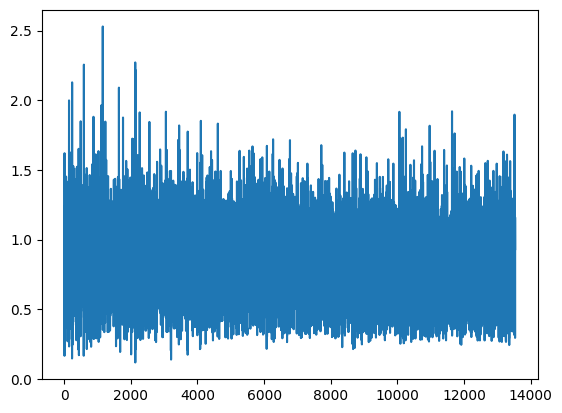

In [24]:
plt.plot(train_losses)

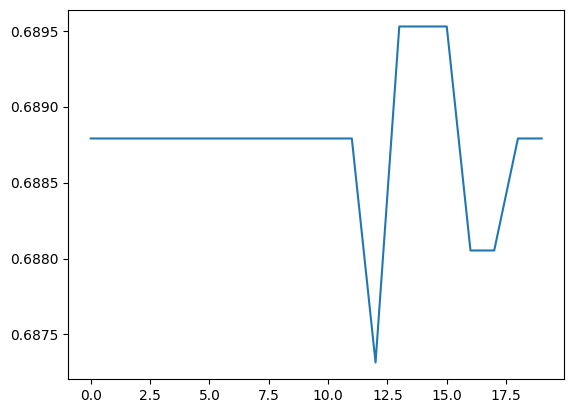

In [25]:
plt.plot(test_accuracy)

In [26]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 934/1352 (0.6908)
{'acc_detail': tensor([0.9968, 0.0000, 0.0116], device='cuda:0'),
 'acc_unweighted': tensor(0.3361, device='cuda:0'),
 'acc_weighted': tensor(0.6908, device='cuda:0'),
 'f1s': tensor(0.2800, device='cuda:0'),
 'f1s_detail': tensor([0.8174, 0.0000, 0.0226], device='cuda:0'),
 'precision_detail': tensor([0.6927, 0.0000, 0.4286], device='cuda:0'),
 'recall_detail': tensor([0.9968, 0.0000, 0.0116], device='cuda:0'),
 'rocauc': tensor([0.5813, 0.5589, 0.6318], device='cuda:0'),
 'uar': tensor(0.3361, device='cuda:0'),
 'wap': tensor(0.5603, device='cuda:0')}


tensor([[931,   1,   2],
        [158,   0,   2],
        [255,   0,   3]], device='cuda:0')

In [27]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_meld4/meld3_m18emo4_best_14epoch.pt
Correct: 935/1352 (0.6916)
{'acc_detail': tensor([0.9979, 0.0063, 0.0078], device='cuda:0'),
 'acc_unweighted': tensor(0.3373, device='cuda:0'),
 'acc_weighted': tensor(0.6916, device='cuda:0'),
 'f1s': tensor(0.2819, device='cuda:0'),
 'f1s_detail': tensor([0.8183, 0.0124, 0.0151], device='cuda:0'),
 'precision_detail': tensor([0.6935, 1.0000, 0.2857], device='cuda:0'),
 'recall_detail': tensor([0.9979, 0.0063, 0.0078], device='cuda:0'),
 'rocauc': tensor([0.5798, 0.5606, 0.6291], device='cuda:0'),
 'uar': tensor(0.3373, device='cuda:0'),
 'wap': tensor(0.6519, device='cuda:0')}


tensor([[932,   0,   2],
        [156,   1,   3],
        [256,   0,   2]], device='cuda:0')

In [28]:
from IConNet.visualizer import visualize_model

layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0009],
        [0.0018],
        [0.0027],
        [0.0036],
        [0.0045],
        [0.0055],
        [0.0065],
        [0.0075],
        [0.0085],
        [0.0095],
        [0.0106],
        [0.0117],
        [0.0128],
        [0.0139],
        [0.0150],
        [0.0162],
        [0.0174],
        [0.0186],
        [0.0198],
        [0.0211],
        [0.0224],
        [0.0237],
        [0.0251],
        [0.0264],
        [0.0278],
        [0.0292],
        [0.0307],
        [0.0322],
        [0.0337],
        [0.0352],
        [0.0368],
        [0.0384],
        [0.0400],
        [0.0417],
        [0.0434],
        [0.0451],
        [0.0469],
        [0.0487],
        [0.0505],
        [0.0524],
        [0.0543],
        [0.0563],
        [0.0583],
        [0.0603],
        [0.0624],
        [0.0645],
        [0.0666],
        [0.0688],
        [0.0710],
        [0.0733],
        [0.0757],
        [0.0780],
       

(array([35., 28., 27., 24., 20., 21., 19., 17., 17., 16., 15., 14., 14.,
        13., 13., 11., 12., 10., 13., 11., 10.,  8., 11.,  9.,  9.,  8.,
        10.,  9.,  7.,  9.,  7.,  9.,  7.,  7.,  7.,  7.,  6.,  8.,  6.,
         8.]),
 array([0.        , 0.0123532 , 0.02470641, 0.03705961, 0.04941281,
        0.06176602, 0.07411922, 0.08647242, 0.09882563, 0.11117883,
        0.12353203, 0.13588524, 0.14823844, 0.16059165, 0.17294484,
        0.18529806, 0.19765125, 0.21000446, 0.22235766, 0.23471087,
        0.24706407, 0.25941727, 0.27177048, 0.28412369, 0.29647687,
        0.30883008, 0.32118329, 0.33353651, 0.34588969, 0.3582429 ,
        0.37059611, 0.38294929, 0.3953025 , 0.40765572, 0.42000893,
        0.43236211, 0.44471532, 0.45706853, 0.46942174, 0.48177493,
        0.49412814]),
 <BarContainer object of 40 artists>)

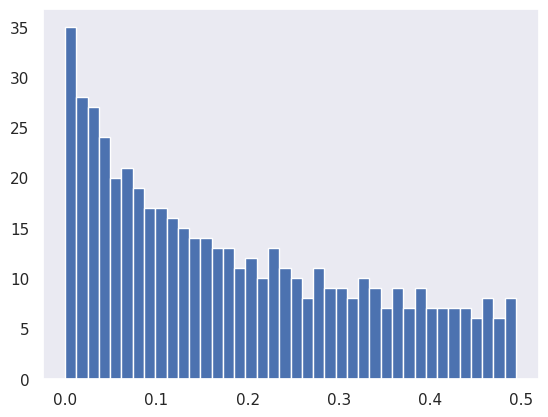

In [29]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   2.,  15., 483.,   2.,   1.,
          1.,   0.,   1.,   0.,   1.,   1.,   1.]),
 array([-6.59407560e-14, -6.37541303e-14, -6.15675113e-14, -5.93808856e-14,
        -5.71942667e-14, -5.50076444e-14, -5.28210186e-14, -5.06343963e-14,
        -4.84477740e-14, -4.62611516e-14, -4.40745293e-14, -4.18879070e-14,
        -3.97012847e-14, -3.75146623e-14, -3.53280400e-14, -3.31414177e-14,
        -3.09547953e-14, -2.87681730e-14, -2.65815490e-14, -2.43949267e-14,
        -2.22083026e-14, -2.00216803e-14, -1.78350580e-14, -1.56484356e-14,
        -1.34618133e-14, -1.12751901e-14, -9.08856781e-15, -6.90194506e-15,
        -4.71532230e-15, -2.52869976e-15, -3.42077220e-16,  1.84454532e-15,
         4.03116786e-15,  6.21779062e-15,  8.40441337e-15,  1.05910357e-14,
         1.27776589e-14,  1.49642804e-14, 

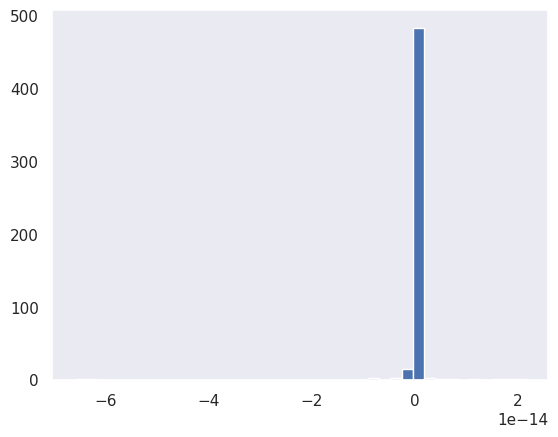

In [30]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

/tmp/ipykernel_3247522/1402059949.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands.flatten())
/tmp/ipykernel_3247522/1402059949.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands.flatten())


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  3.,  4.,  4.,  1.,
         4., 13.,  5., 12., 25., 16., 14., 13.,  9.,  8.,  9.,  7.,  7.,
         2.,  6.,  3.,  4.,  2.,  2.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         3.]),
 array([-47.45703506, -47.05735016, -46.65766144, -46.25797653,
        -45.85829163, -45.45860672, -45.05892181, -44.65923309,
        -44.25954819, -43.85986328, -43.46017456, -43.06048965,
        -42.66080475, -42.26111984, -41.86143494, -41.46174622,
        -41.06206131, -40.6623764 , -40.26268768, -39.86300278,
        -39.46331787, -39.06363297, -38.66394806, -38.26425934,
        -37.86457443, -37.46488953, -37.06520081, -36.6655159 ,
        -36.26583099, -35.86614609, -35.46646118, -35.06677246,
        -34.66708755, -34.26740265, -33.86771393, -33.46802902,
        -33.06834412, -32.66865921, -32.2689743 , -31.86928558,
        -31.46960068]),
 <BarContainer object of 40 artists>)

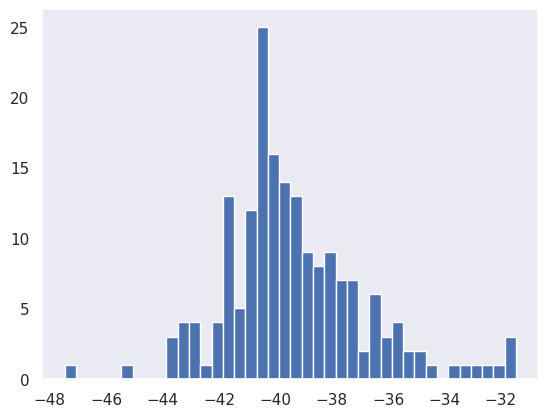

In [31]:
grad_log = np.log(lowbands.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([13., 13., 19., 17., 27., 23., 29., 32., 29., 28., 26., 23., 22.,
        22., 20., 18., 18., 17., 16., 16., 11.,  9.,  9.,  7.,  9.,  6.,
         4.,  3.,  4.,  3.,  4.,  3.,  3.,  1.,  1.,  2.,  1.,  1.,  1.,
         2.]),
 array([0.00086986, 0.00111313, 0.00135639, 0.00159965, 0.00184291,
        0.00208618, 0.00232944, 0.0025727 , 0.00281597, 0.00305923,
        0.00330249, 0.00354575, 0.00378902, 0.00403228, 0.00427554,
        0.00451881, 0.00476207, 0.00500533, 0.0052486 , 0.00549186,
        0.00573512, 0.00597838, 0.00622165, 0.00646491, 0.00670817,
        0.00695144, 0.0071947 , 0.00743796, 0.00768122, 0.00792449,
        0.00816775, 0.00841101, 0.00865428, 0.00889754, 0.0091408 ,
        0.00938406, 0.00962733, 0.00987059, 0.01011385, 0.01035712,
        0.01060038]),
 <BarContainer object of 40 artists>)

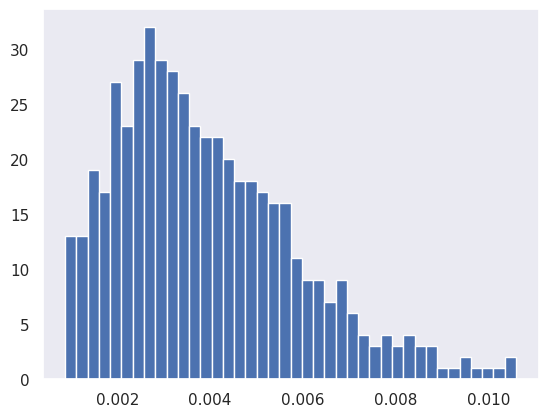

In [32]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   0.,   0., 504.,   2.,   2.]),
 array([-6.59396921e-14, -6.41795577e-14, -6.24194164e-14, -6.06592820e-14,
        -5.88991407e-14, -5.71390063e-14, -5.53788650e-14, -5.36187272e-14,
        -5.18585893e-14, -5.00984548e-14, -4.83383170e-14, -4.65781791e-14,
        -4.48180413e-14, -4.30579034e-14, -4.12977656e-14, -3.95376277e-14,
        -3.77774899e-14, -3.60173520e-14, -3.42572142e-14, -3.24970763e-14,
        -3.07369385e-14, -2.89768006e-14, -2.72166628e-14, -2.54565266e-14,
        -2.36963888e-14, -2.19362509e-14, -2.01761130e-14, -1.84159752e-14,
        -1.66558373e-14, -1.48956995e-14, -1.31355625e-14, -1.13754246e-14,
        -9.61528678e-15, -7.85514892e-15, -6.09501150e-15, -4.33487407e-15,
        -2.57473621e-15, -8.14598626e-16, 

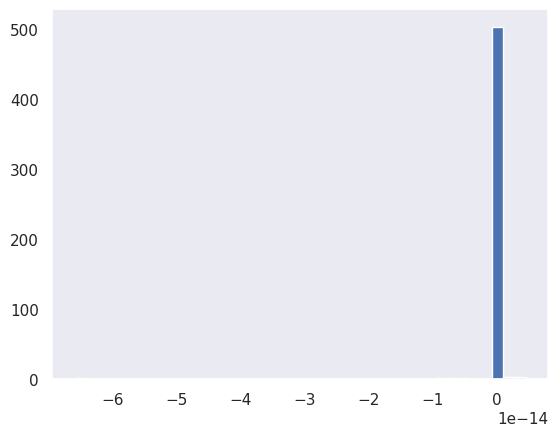

In [33]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

/tmp/ipykernel_3247522/1421197636.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths.flatten()), bins=40)


(array([ 2.,  2.,  0.,  1.,  0.,  1.,  3.,  0.,  2.,  5.,  1., 13.,  7.,
         6.,  7.,  3.,  5.,  3.,  5.,  2.,  1.,  2.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,
         1.]),
 array([-45.81519699, -45.49587631, -45.17655182, -44.85723114,
        -44.53791046, -44.21858978, -43.89926529, -43.57994461,
        -43.26062393, -42.94129944, -42.62197876, -42.30265808,
        -41.98333359, -41.66401291, -41.34469223, -41.02536774,
        -40.70604706, -40.38672638, -40.0674057 , -39.74808121,
        -39.42876053, -39.10943985, -38.79011536, -38.47079468,
        -38.151474  , -37.83215332, -37.51282883, -37.19350815,
        -36.87418747, -36.55486298, -36.2355423 , -35.91622162,
        -35.59689713, -35.27757645, -34.95825577, -34.63893127,
        -34.3196106 , -34.00028992, -33.68096924, -33.36164474,
        -33.04232407]),
 <BarContainer object of 40 artists>)

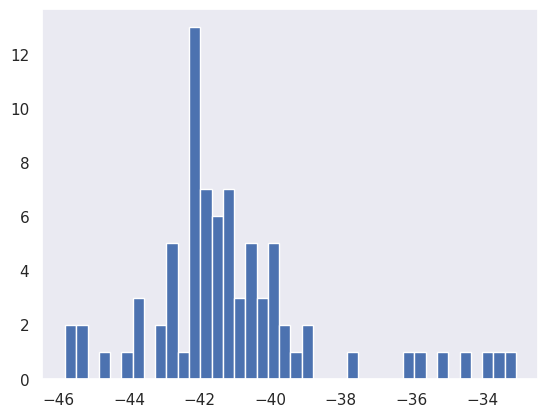

In [34]:
plt.hist(np.log(bandwidths.flatten()), bins=40)

(array([   9.,   18.,   30.,   46.,  109.,  116.,  160.,  214.,  280.,
         348.,  496.,  661.,  747.,  747.,  764.,  909.,  955., 1038.,
        1083., 1164., 1297., 1452., 1687., 1638., 1552., 1358., 1301.,
        1191., 1005.,  740.,  543.,  370.,  242.,  135.,   64.,   45.,
          34.,   16.,    9.,    3.]),
 array([-0.71349466, -0.65257198, -0.59164923, -0.53072655, -0.46980381,
        -0.40888113, -0.34795842, -0.2870357 , -0.22611299, -0.16519028,
        -0.10426757, -0.04334486,  0.01757785,  0.07850056,  0.13942327,
         0.20034598,  0.26126868,  0.32219139,  0.3831141 ,  0.44403681,
         0.50495952,  0.56588221,  0.62680495,  0.68772763,  0.74865037,
         0.80957305,  0.8704958 ,  0.93141848,  0.99234122,  1.0532639 ,
         1.11418664,  1.17510927,  1.23603201,  1.29695475,  1.35787749,
         1.41880012,  1.47972286,  1.5406456 ,  1.60156834,  1.66249096,
         1.72341371]),
 <BarContainer object of 40 artists>)

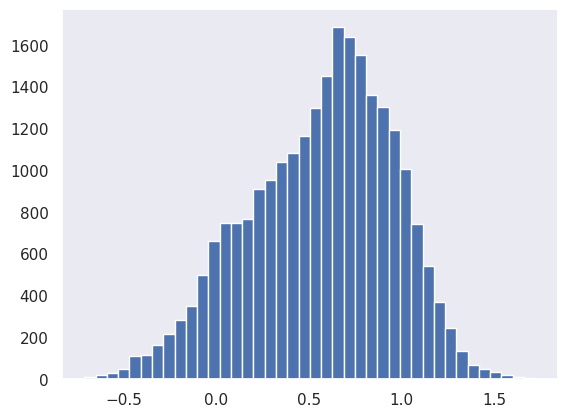

In [35]:
window_params = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

(array([1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 7.000e+00, 9.000e+00,
        2.200e+01, 2.800e+01, 4.900e+01, 7.100e+01, 1.120e+02, 1.510e+02,
        2.830e+02, 4.460e+02, 6.450e+02, 9.280e+02, 1.225e+03, 1.801e+03,
        2.660e+03, 5.104e+03, 4.041e+03, 2.465e+03, 1.462e+03, 1.106e+03,
        7.020e+02, 4.190e+02, 2.850e+02, 1.920e+02, 1.050e+02, 9.200e+01,
        6.000e+01, 4.700e+01, 2.400e+01, 1.300e+01, 7.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([-4.84676973e-04, -4.60232754e-04, -4.35788534e-04, -4.11344285e-04,
        -3.86900065e-04, -3.62455845e-04, -3.38011596e-04, -3.13567376e-04,
        -2.89123156e-04, -2.64678936e-04, -2.40234702e-04, -2.15790467e-04,
        -1.91346247e-04, -1.66902028e-04, -1.42457793e-04, -1.18013566e-04,
        -9.35693388e-05, -6.91251116e-05, -4.46808845e-05, -2.02366573e-05,
         4.20756987e-06,  2.86517970e-05,  5.30960242e-05,  7.75402514e-05,
         1.01984479e-04,  1.26428698e-04,  1.5

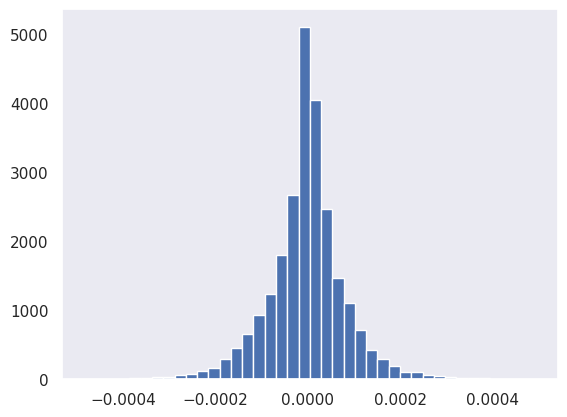

In [36]:
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

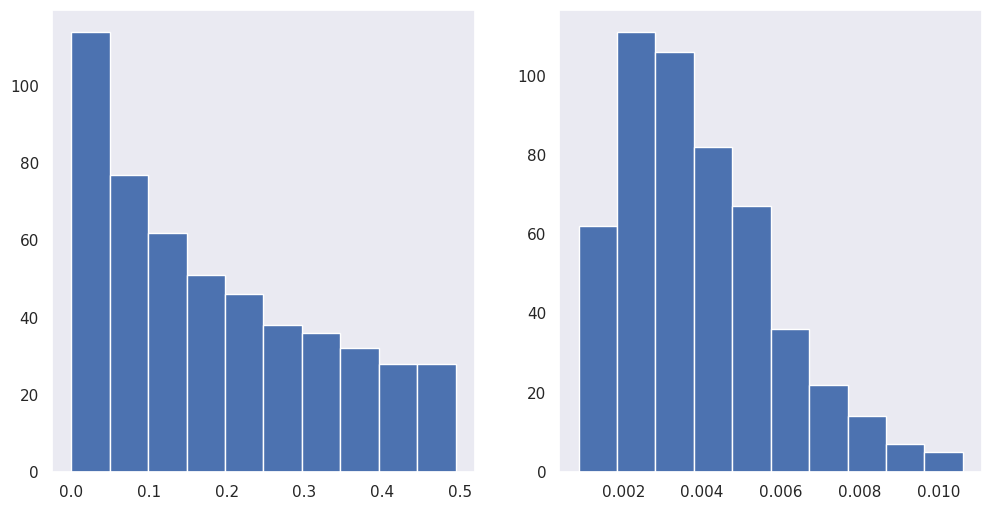

In [37]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


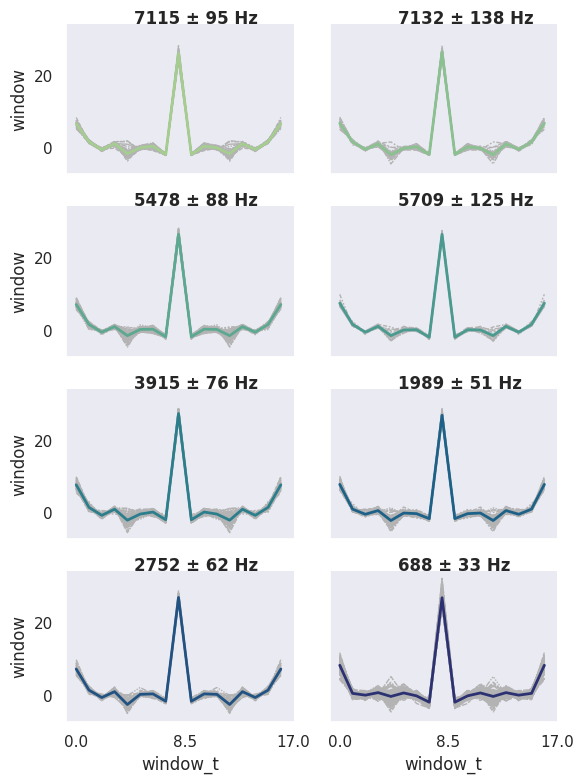

In [38]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


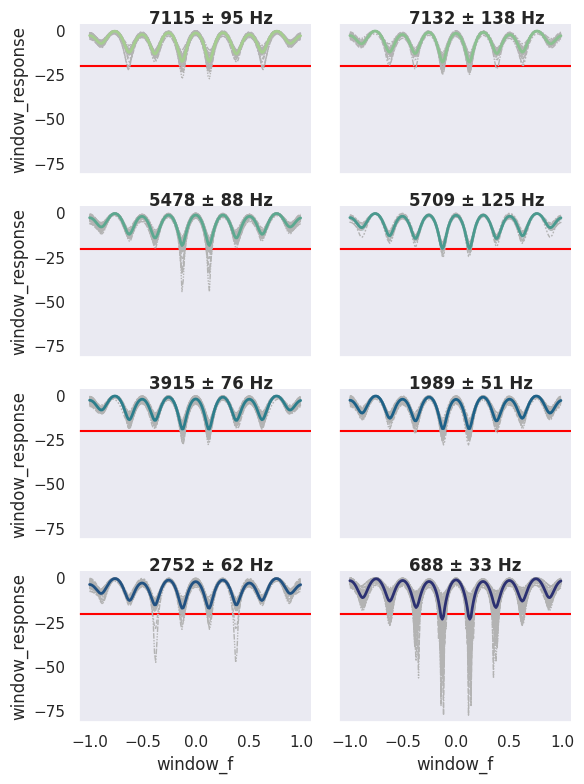

In [39]:
filtviz.visualize_filters(filter_domain='freq')

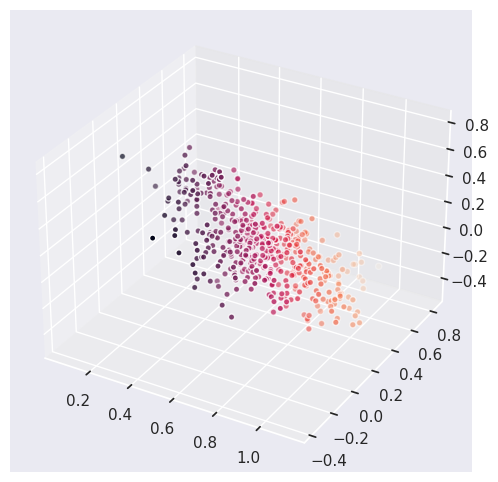

In [40]:
filtviz.visualize_window_params()